In [68]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import random 

plt.style.use(['science', 'retro', 'grid'])

import sys
import cvxopt as opt
sys.path.insert(0, os.path.abspath('../../src/rl/dir_vec/'))
sys.path.insert(1, os.path.abspath('../../src/rl/environments/'))
sys.path.insert(1, os.path.abspath('../../src/rl/environments/base'))
sys.path.insert(2, os.path.abspath('../../src/mpt/efficient_frontier/'))
sys.path.insert(3, os.path.abspath('../../src/mpt/utils'))


In [69]:
import importlib
importlib.reload(sys.modules['EfficientFrontier'])
importlib.reload(sys.modules['MarketFactory'])
importlib.reload(sys.modules['GenerativeMarketEnv'])
importlib.reload(sys.modules['HarnessVec'])
importlib.reload(sys.modules['ParallelRunnerVec'])
importlib.reload(sys.modules['DirichletPolicyVec'])

<module 'DirichletPolicyVec' from '/Users/michael/UCL/Disertation/porfolio-optimisation/src/rl/dir_vec/DirichletPolicyVec.py'>

In [70]:
from GenerativeMarketEnv import GenerativeMarketEnv
from DirichletPolicyVec import DirichletPolicyVec
from HarnessVec import HarnessVec
from ParallelRunnerVec import ParallelRunnerVec
from EfficientFrontier import EfficientFrontier
from MarketFactory import MarketFactory

# Investigation of the Viability of the Dirichlet Policy on Real Stock

This notebook looks at optimising for real stocks.  We calculate the empirical means and covariance matrices of a number of stocks and create a generative environment (multivariate Gaussian). This enables us to plot the efficient frontier for the assets (blue line in plots is EF, yellow crosses are the assets) and the maximum Sharpe ratio (pink cross).

We then learn the policy, first optimising for returns and then the differential Sharpe ratio. Once a policy has been learned we generate a series of returns and plot the empirical mean return and volatility (cyan dots). 

In [71]:
# stocks to consider 
stocks = ['AAPL' ,'ADBE' ,'ADI' ,'ADP' ,'ADSK' ,'AEP' ,'ALGN' ,'ALXN' ,'AMAT' ,'AMD' ,'AMGN' ,'AMZN' ,'ANSS' ,'ASML' ,'ATVI'
 ,'AVGO' ,'BIDU' ,'BIIB' ,'BKNG' ,'CDNS' ,'CDW' ,'CERN' ,'CHKP' ,'CHTR' ,'CMCSA' ,'COST' ,'CPRT' ,'CSCO' ,'CSX' ,'CTAS'
 ,'CTSH' ,'DLTR' ,'DOCU' ,'DXCM' ,'EA' ,'EBAY' ,'EXC' ,'FAST' ,'FB' ,'FISV' ,'FOX' ,'FOXA' ,'GILD' ,'GOOG' ,'GOOGL'
 ,'IDXX' ,'ILMN' ,'INCY' ,'INTC' ,'INTU' ,'ISRG' ,'JD' ,'KDP' ,'KHC' ,'KLAC' ,'LRCX' ,'LULU' ,'MAR' ,'MCHP' ,'MDLZ'
 ,'MELI' ,'MNST' ,'MRNA' ,'MRVL' ,'MSFT' ,'MTCH' ,'MU' ,'MXIM' ,'NFLX' ,'NTES' ,'NVDA' ,'NXPI' ,'OKTA' ,'ORLY' ,'PAYX'
 ,'PCAR' ,'PDD' ,'PEP' ,'PTON' ,'PYPL' ,'QCOM' ,'REGN' ,'ROST' ,'SBUX' ,'SGEN' ,'SIRI' ,'SNPS' ,'SPLK' ,'SWKS' ,'TCOM'
 ,'TEAM' ,'TMUS' ,'TSLA' ,'TXN' ,'VRSK' ,'VRSN' ,'VRTX' ,'WBA' ,'WDAY' ,'XEL' ,'XLNX' ,'ZM']

## Maximising Returns of Real Stocks

### 10 Stocks

In [72]:
random.shuffle(stocks)
# sampled_stocks_10 = stocks[:10]
sampled_stocks_10 = ['REGN', 'AMD', 'MELI', 'CTSH', 'VRTX', 'BIDU', 'KDP', 'ADI', 'MNST', 'ANSS']

[*********************100%***********************]  10 of 10 completed


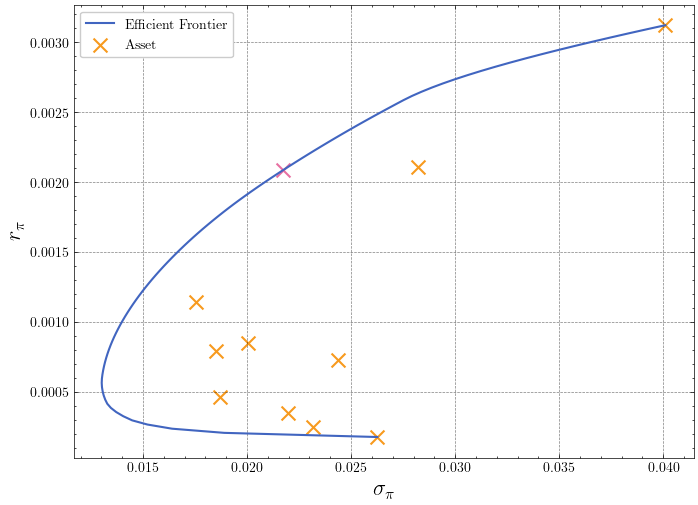

0.09604282392993145

In [73]:
factory = MarketFactory(sampled_stocks_10, "2015-01-01", "2021-01-01")
market = factory.create_market()
market.plot_efficient_frontier()

In [79]:
params = {
    'n_assets': len(sampled_stocks_10),
    'α': 1,
    'α_end': 0.1,
    'start_ep': 2000, 
    'α_decay_steps': 6000,
    'γ': 0.1,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': 'avg_r_baseline',
    'parameterisation': 'softplus',
    'eps': 10000
}

p_runner = ParallelRunnerVec(market.μ, market.Σ, 10, [params], 50, reward_mode='returns')
p_runner.run_test()
means = []
stds = []
for i in range(len(p_runner.results['0'])):
    means.append(np.mean(p_runner.results['0'][i]))
    stds.append(np.std(p_runner.results['0'][i]))

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 4038.42it/s]
1it [02:53, 173.83s/it]


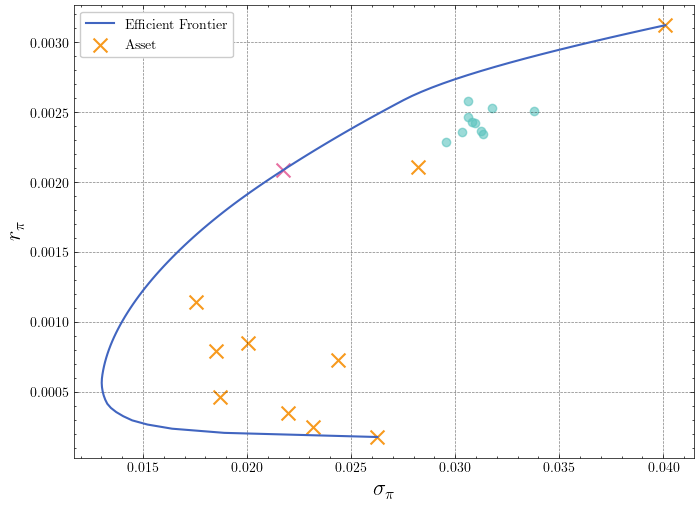

0.09604282392993145

In [80]:
market.plot_efficient_frontier(stds = stds, returns = means)

In [179]:
params = {
    'n_assets': len(sampled_stocks_10),
    'α': 40,
    'α_end': 0.2,
    'start_ep': 6000, 
    'α_decay_steps': 6000,
    'γ': 0.1,
    'grad_adpt_mode': 'max_digamma',
    'returns_adpt_mode': 'avg_r_baseline',
    'parameterisation': 'softplus',
    'eps': 10000
}

p_runner = ParallelRunnerVec(market.μ, market.Σ, 10, [params], 50, reward_mode='returns')
p_runner.run_test()
means = []
stds = []
for i in range(len(p_runner.results['0'])):
    means.append(np.mean(p_runner.results['0'][i]))
    stds.append(np.std(p_runner.results['0'][i]))

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 3649.76it/s]
1it [01:02, 62.20s/it]


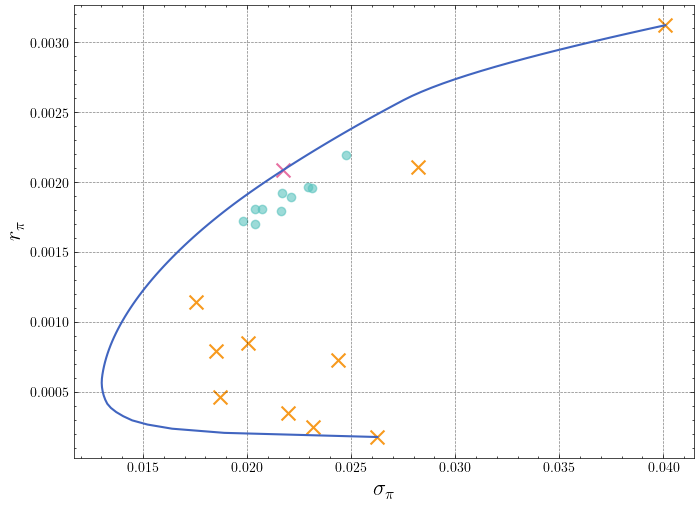

0.09604282392993145

In [180]:
market.plot_efficient_frontier(stds = stds, returns = means, save_name='./dirichlet_10')

### 15 stocks

In [188]:
random.shuffle(stocks)
sampled_stocks_15 = stocks[:10]

In [189]:
sampled_stocks_15

['MNST', 'JD', 'CDNS', 'CMCSA', 'FAST', 'LRCX', 'ALGN', 'VRSN', 'GOOG', 'ALXN']

[*********************100%***********************]  10 of 10 completed


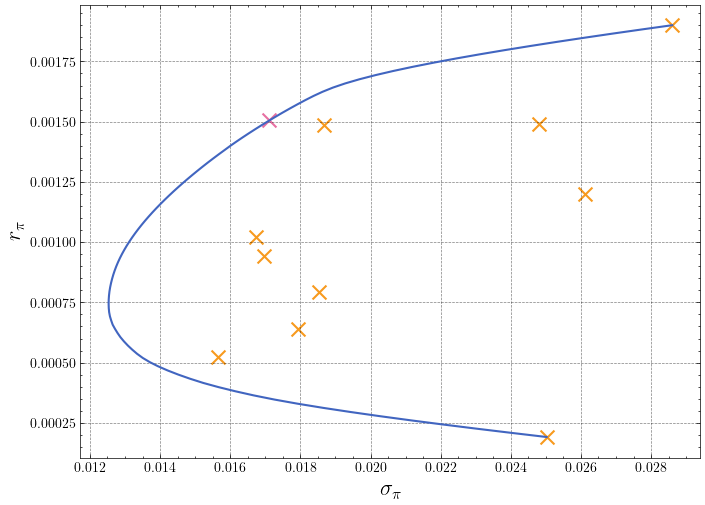

0.08794216599084484

In [190]:
factory = MarketFactory(sampled_stocks_15, "2015-01-01", "2021-01-01")
market = factory.create_market()
market.plot_efficient_frontier()

In [201]:
params = {
    'n_assets': len(sampled_stocks_10),
    'α': 10,
    'α_end': 0.01,
    'start_ep': 4000, 
    'α_decay_steps': 6000,
    'γ': 0.1,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': 'avg_r_baseline',
    'parameterisation': 'softplus',
    'eps': 10000
}

p_runner = ParallelRunnerVec(market.μ, market.Σ, 10, [params], 50, reward_mode='returns')
p_runner.run_test()
means = []
stds = []
for i in range(len(p_runner.results['0'])):
    means.append(np.mean(p_runner.results['0'][i]))
    stds.append(np.std(p_runner.results['0'][i]))

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 57.20it/s]
1it [03:06, 186.33s/it]


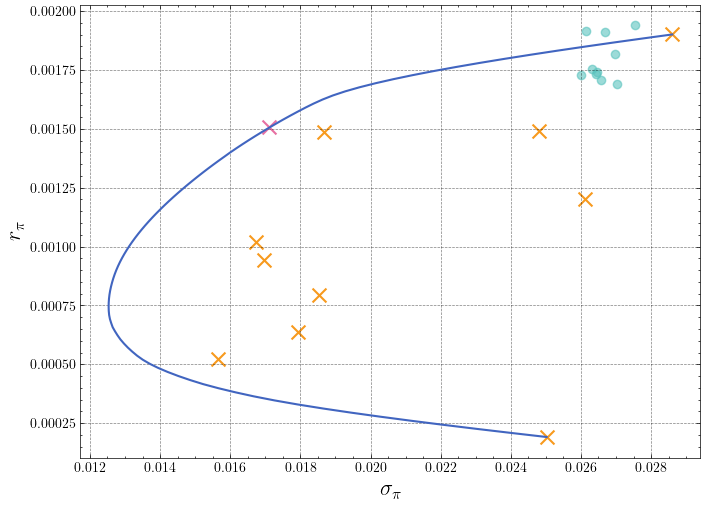

0.08794216599084484

In [200]:
market.plot_efficient_frontier(stds = stds, returns = means)

### 25 Stocks

In [247]:
random.shuffle(stocks)
sampled_stocks_25 = stocks[:25]
factory = MarketFactory(sampled_stocks_25, "2015-01-01", "2021-01-01")

[*********************100%***********************]  25 of 25 completed


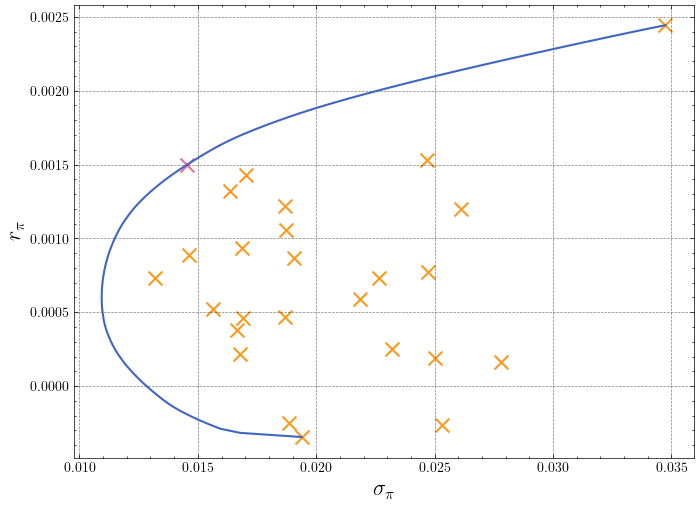

0.10308343623475925

In [248]:
market = factory.create_market()
market.plot_efficient_frontier()

In [257]:
params = {
    'n_assets': len(sampled_stocks_25),
    'α': 20,
    'α_end': 1,
    'start_ep': 4000, 
    'α_decay_steps': 4000,
    'γ': 0.1,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': 'avg_r_baseline',
    'parameterisation': 'softplus',
    'eps': 10000
}

p_runner = ParallelRunnerVec(market.μ, market.Σ, 10, [params], 50, reward_mode='returns')
p_runner.run_test()
means = []
stds = []
for i in range(len(p_runner.results['0'])):
    means.append(np.mean(p_runner.results['0'][i]))
    stds.append(np.std(p_runner.results['0'][i]))

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 4061.49it/s]
1it [03:30, 210.87s/it]


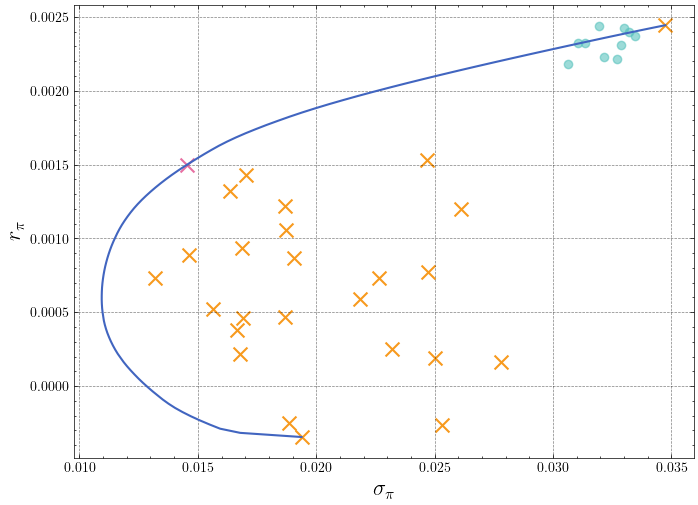

0.10308343623475925

In [259]:
market.plot_efficient_frontier(stds = stds, returns = means, save_name='dir_25')

In [260]:
sampled_stocks_25

['KHC',
 'MXIM',
 'QCOM',
 'AMGN',
 'JD',
 'FOXA',
 'SNPS',
 'BIIB',
 'EXC',
 'CPRT',
 'AAPL',
 'COST',
 'CDW',
 'GOOGL',
 'BIDU',
 'ALXN',
 'WBA',
 'CTSH',
 'LULU',
 'CMCSA',
 'TSLA',
 'ILMN',
 'CSCO',
 'MAR',
 'VRSK']

### 50 Stocks 

In [217]:
random.shuffle(stocks)
sampled_stocks_50 = ['SBUX',
 'PCAR',
 'WDAY',
 'ORLY',
 'ILMN',
 'CTAS',
 'MDLZ',
 'FAST',
 'MRVL',
 'NFLX',
 'AMD',
 'FB',
 'MRNA',
 'QCOM',
 'GILD',
 'ROST',
 'AVGO',
 'ADSK',
 'INTU',
 'IDXX',
 'XEL',
 'AMAT',
 'MSFT',
 'ADP',
 'XLNX',
 'LRCX',
 'PDD',
 'DOCU',
 'TCOM',
 'EA',
 'LULU',
 'VRSK',
 'SGEN',
 'ALXN',
 'ANSS',
 'CTSH',
 'PYPL',
 'CSCO',
 'CMCSA',
 'PEP',
 'CSX',
 'FOXA',
 'MELI',
 'ALGN',
 'NVDA',
 'VRSN',
 'SPLK',
 'KDP',
 'CPRT',
 'MAR']
factory = MarketFactory(sampled_stocks_50, "2015-01-01", "2021-01-01")

[*********************100%***********************]  50 of 50 completed


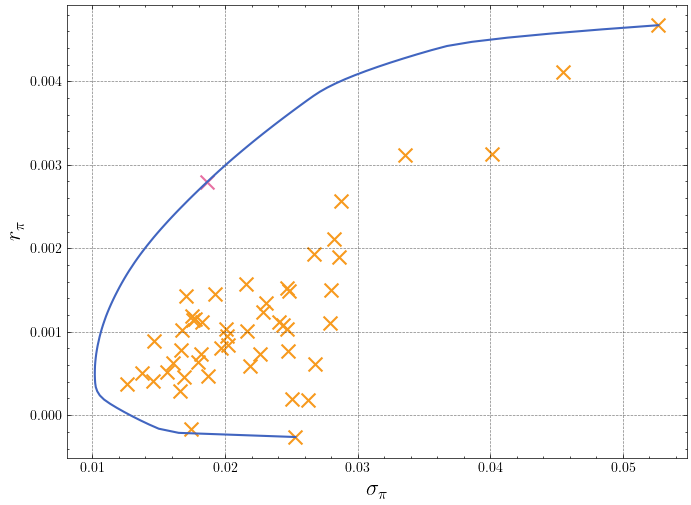

0.1498466263395621

In [218]:
market = factory.create_market()
market.plot_efficient_frontier()

In [245]:
params = {
    'n_assets': len(sampled_stocks_50),
    'α': 20,
    'α_end': 2,
    'start_ep': 5000, 
    'α_decay_steps': 10000,
    'γ': 0.1,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 10000
}

p_runner = ParallelRunnerVec(market.μ, market.Σ, 4, [params], 50, reward_mode='returns')
p_runner.run_test()
means = []
stds = []
for i in range(len(p_runner.results['0'])):
    means.append(np.mean(p_runner.results['0'][i]))
    stds.append(np.std(p_runner.results['0'][i]))

0it [00:00, ?it/s]
100%|██████████| 4/4 [00:00<00:00, 3716.71it/s]
1it [02:36, 156.46s/it]


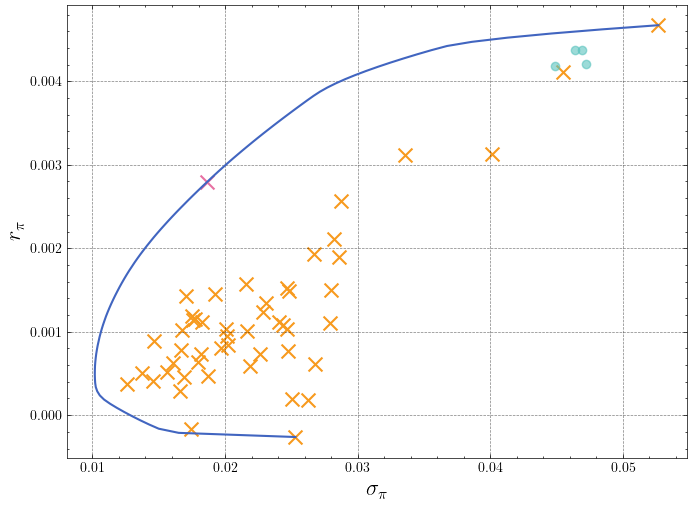

0.1498466263395621

In [246]:
market.plot_efficient_frontier(stds = stds, returns = means, save_name='dir_50')

### 100 Stocks

In [265]:
random.shuffle(stocks)
sampled_stocks_50 = stocks[:100]
factory = MarketFactory(sampled_stocks_50, "2015-01-01", "2021-01-01")

[*********************100%***********************]  100 of 100 completed


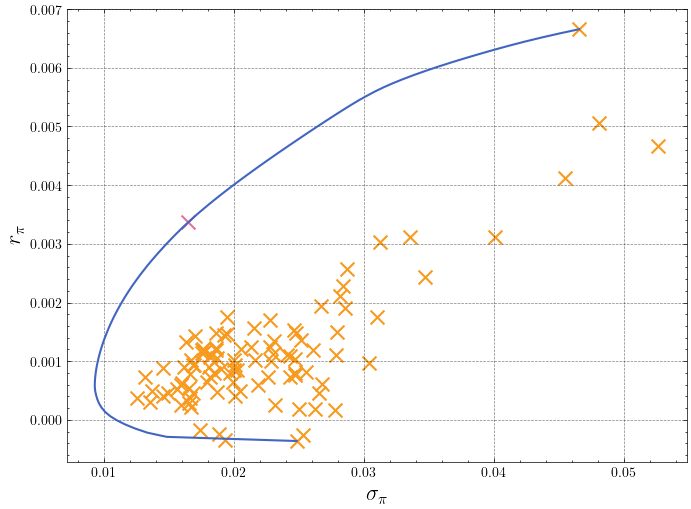

0.20397540768498823

In [267]:
market = factory.create_market()
market.plot_efficient_frontier()

In [279]:
params = {
    'n_assets': len(sampled_stocks_50),
    'α': 20,
    'α_end': 4,
    'start_ep': 8000, 
    'α_decay_steps': 8000,
    'γ': 0.1,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': 'avg_r_baseline',
    'parameterisation': 'softplus',
    'eps': 25000
}

p_runner = ParallelRunnerVec(market.μ, market.Σ, 10, [params], 50, reward_mode='returns')
p_runner.run_test()
means = []
stds = []
for i in range(len(p_runner.results['0'])):
    means.append(np.mean(p_runner.results['0'][i]))
    stds.append(np.std(p_runner.results['0'][i]))

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 59.02it/s]
1it [32:05, 1925.18s/it]


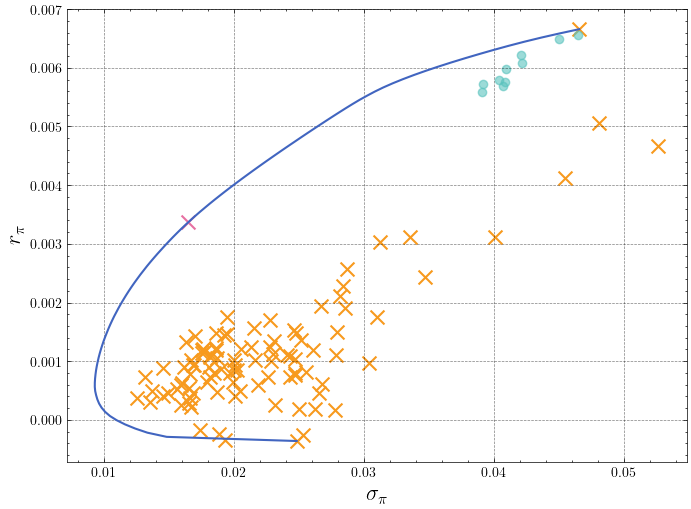

0.20397540768498826

In [280]:
market.plot_efficient_frontier(stds = stds, returns = means, save_name='dir_100')

## Maximising the Differential Sharpe Ratio of Real Stocks

The Sharpe ratio is a measure of risk-adjusted return. It is defined as 

$$S_t = \frac{\text{Ave}(R_t)}{\text{Std}(R_t)} $$

Moody et al. 1998 derive an online learning friendly objective called the *differential Sharpe ratio*. It is calculated using exponential moving averages of the returns and standard deviation of returns and then considering a first-order expansion around the decay rate.

$$S_t \approx S_{t-1} + \eta \left.  \frac{d S_t}{d \eta} \right|_{\eta=0} + \mathcal{O}(\eta^2)$$

The *differential Sharpe ratio* is then defined as 

$$D_t = \frac{d S_t}{d \eta} = \frac{B_{t-1} \Delta A_t - \frac{1}{2} A_{t-1} \Delta B_t}{(B_{t-1} - A^2_{t-1})^{\frac{3}{2}}}$$

Where $A_t$ and $B_t$ are exponential moving estimates of the first and second moments of the returns at time t or

$$A_t = A_{t-1} + \eta(R_t - A_{t-1})$$

$$B_t = B_{t-1} + \eta(R^2_t - B_{t-1})$$

### 10 Stocks

[*********************100%***********************]  10 of 10 completed


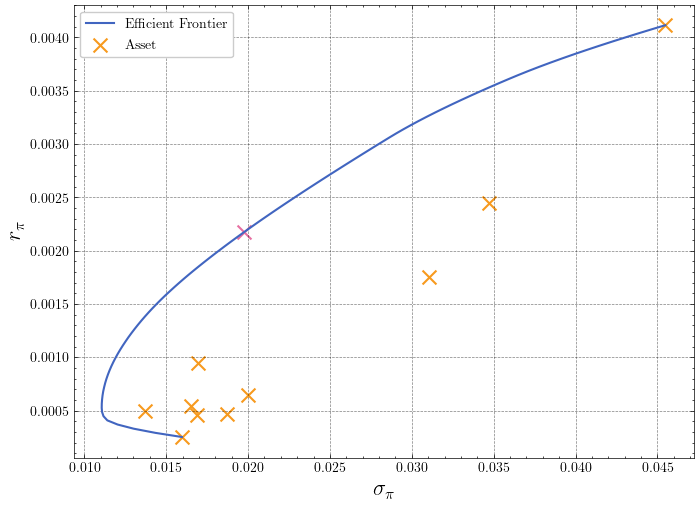

0.11003715610100549

In [57]:
random.shuffle(stocks)
sampled_stocks = stocks[:10]
factory = MarketFactory(sampled_stocks, "2015-01-01", "2021-01-01")
market = factory.create_market()
market.plot_efficient_frontier()

In [58]:
sampled_stocks

['SIRI', 'CSCO', 'DXCM', 'CERN', 'XEL', 'CTSH', 'PDD', 'BKNG', 'TSLA', 'GOOG']

In [59]:
params_1 = {
    'n_assets': 10,
    'α': 0.001,
    'α_end': 0.0001,
    'start_ep': 1000, 
    'α_decay_steps': 4000,
    'γ': 0.1,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 10000
}



legend_labels = {'0': 'DSR'}

params = [params_1]
p_runner = ParallelRunnerVec(market.μ, market.Σ, 10, params, 100, legend_labels, reward_mode='dsr', η=0.05)
p_runner.run_test()

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 52.66it/s]
0it [01:41, ?it/s]


KeyboardInterrupt: 

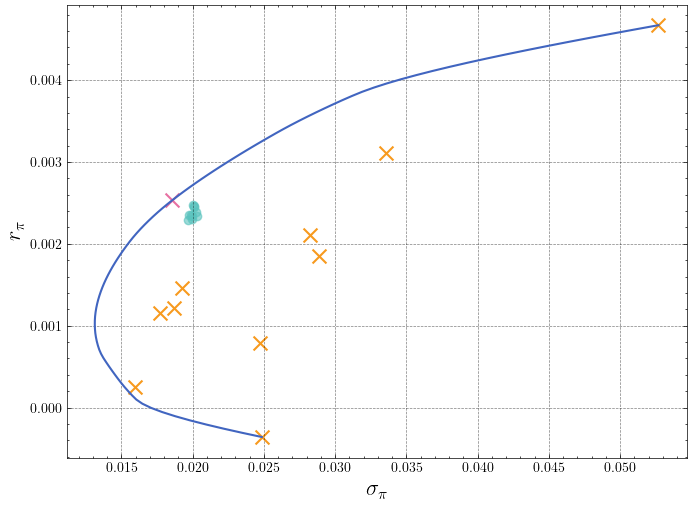

0.13642606497528936

In [41]:
means = []
stds = []
for i in range(len(p_runner.results['0'])):
    means.append(np.mean(p_runner.results['0'][i]))
    stds.append(np.std(p_runner.results['0'][i]))
market.plot_efficient_frontier(stds=stds, returns=means, save_name='dsr_dir_10')

In [65]:
random.shuffle(stocks)
sampled_stocks = stocks[:10]
factory = MarketFactory(sampled_stocks, "2019-01-01", "2021-04-30")

[*********************100%***********************]  10 of 10 completed


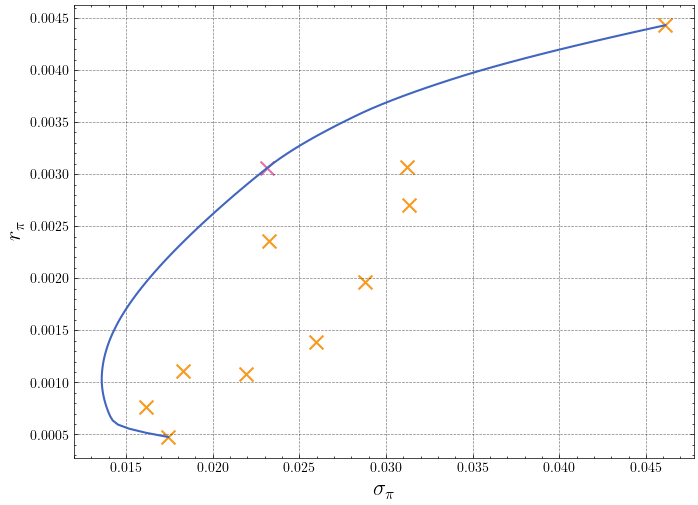

In [63]:
market = factory.create_market()
sr = market.plot_efficient_frontier()

In [96]:
params_1 = {
    'n_assets': 10,
    'α': 0.003,
    'α_end': 0.001,
    'start_ep': 1000, 
    'α_decay_steps': 3000,
    'γ': 0.1,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 10000
}



legend_labels = {'0': 'DSR'}

params = [params_1]
p_runner = ParallelRunnerVec(market.μ, market.Σ, 40, params, 100, legend_labels, reward_mode='dsr', η=0.05)
p_runner.run_test()

0it [00:00, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

 25%|██▌       | 10/40 [00:00<00:00, 69.80it/s]

 25%|██▌       | 10/40 [00:13<00:00, 69.80it/s]

 50%|█████     | 20/40 [05:42<03:25, 10.27s/it]

 75%|███████▌  | 30/40 [10:49<02:44, 16.42s/it]

100%|██████████| 40/40 [16:11<00:00, 24.29s/it]
1it [21:43, 1303.91s/it]


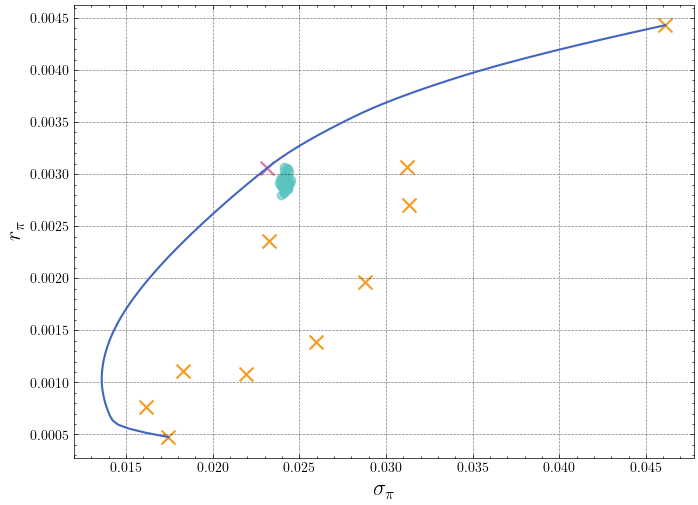

0.13216786633675448

In [97]:
means = []
stds = []
for i in range(len(p_runner.results['0'])):
    means.append(np.mean(p_runner.results['0'][i]))
    stds.append(np.std(p_runner.results['0'][i]))
market.plot_efficient_frontier(stds=stds, returns=means)

In [87]:
means_eq = []
stds_eq = []
for i in range(len(p_runner_eq.results['0'])):
    means_eq.append(np.mean(p_runner_eq.results['0'][i]))
    stds_eq.append(np.std(p_runner_eq.results['0'][i]))

In [98]:
means = []
stds = []
for i in range(len(p_runner.results['0'])):
    means.append(np.mean(p_runner.results['0'][i]))
    stds.append(np.std(p_runner.results['0'][i]))

In [99]:
sharpe = np.array(means)/np.array(stds)

In [100]:
sharpe_eq = np.array(means_eq)/np.array(stds_eq)

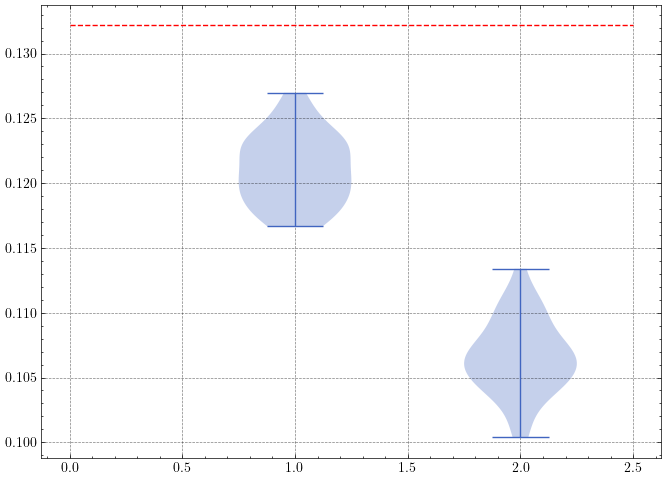

In [101]:
plt.figure(figsize=(8, 6), dpi=100)
plt.violinplot([sharpe, sharpe_eq]);
plt.hlines(y=sr, xmin=0, xmax=2.5, colors='r', linestyles='--')

### 15 Stocks

In [140]:
random.shuffle(stocks)
sampled_stocks = stocks[:15]
factory = MarketFactory(sampled_stocks, "2019-01-01", "2021-04-30")

[*********************100%***********************]  15 of 15 completed


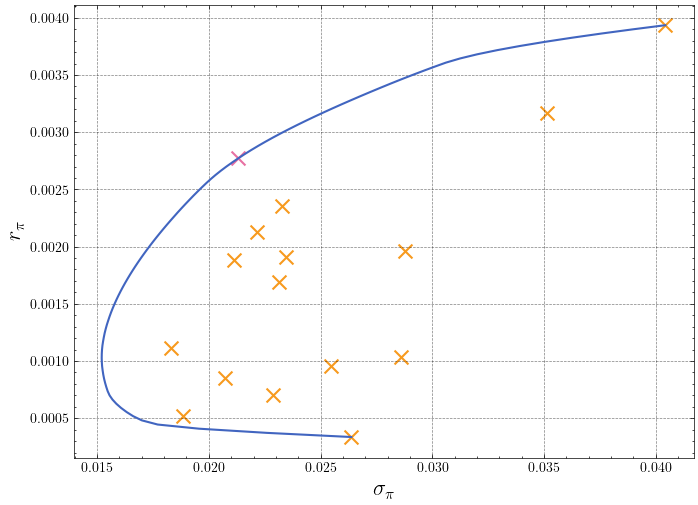

In [141]:
market = factory.create_market()
market.plot_efficient_frontier()

In [144]:
params_1 = {
    'n_assets': 15,
    'α': 0.005,
    'α_end': 0.001,
    'start_ep': 1000, 
    'α_decay_steps': 5000,
    'γ': 0.1,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 9000
}



legend_labels = {'0': 'DSR'}

params = [params_1]
p_runner = ParallelRunnerVec(market.μ, market.Σ, 10, params, 100, legend_labels, reward_mode='dsr', η=0.05)
p_runner.run_test()

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 3280.90it/s]
1it [07:18, 438.35s/it]


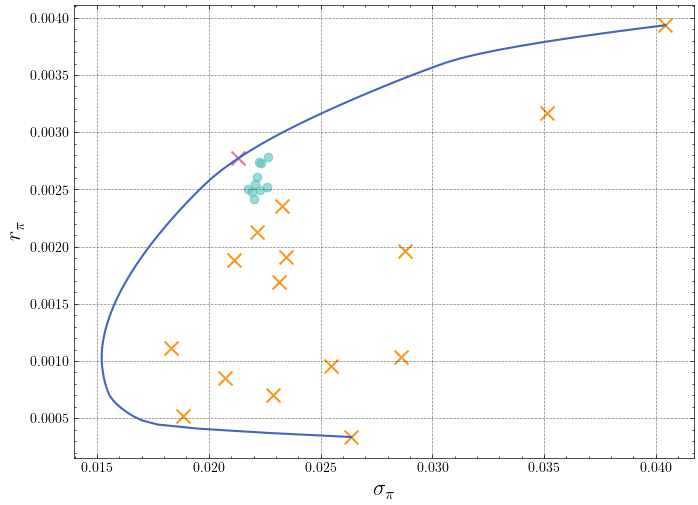

In [146]:
means = []
stds = []
for i in range(len(p_runner.results['0'])):
    means.append(np.mean(p_runner.results['0'][i]))
    stds.append(np.std(p_runner.results['0'][i]))
market.plot_efficient_frontier(stds=stds, returns=means)

### 25 Stocks

In [147]:
random.shuffle(stocks)
sampled_stocks = stocks[:25]
factory = MarketFactory(sampled_stocks, "2019-01-01", "2021-04-30")

[*********************100%***********************]  25 of 25 completed


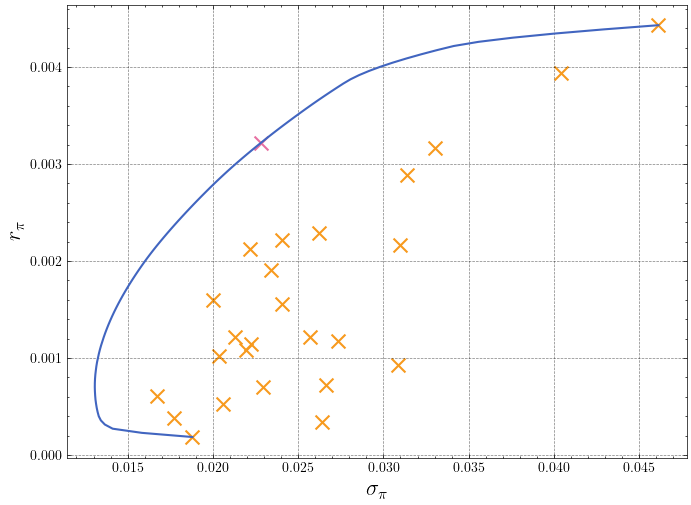

In [149]:
market = factory.create_market()
market.plot_efficient_frontier()

In [150]:
params_1 = {
    'n_assets': 25,
    'α': 0.005,
    'α_end': 0.001,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.1,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 15000
}



legend_labels = {'0': 'DSR'}

params = [params_1]
p_runner = ParallelRunnerVec(market.μ, market.Σ, 10, params, 100, legend_labels, reward_mode='dsr', η=0.05)
p_runner.run_test()

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 1784.81it/s]
1it [13:00, 780.39s/it]


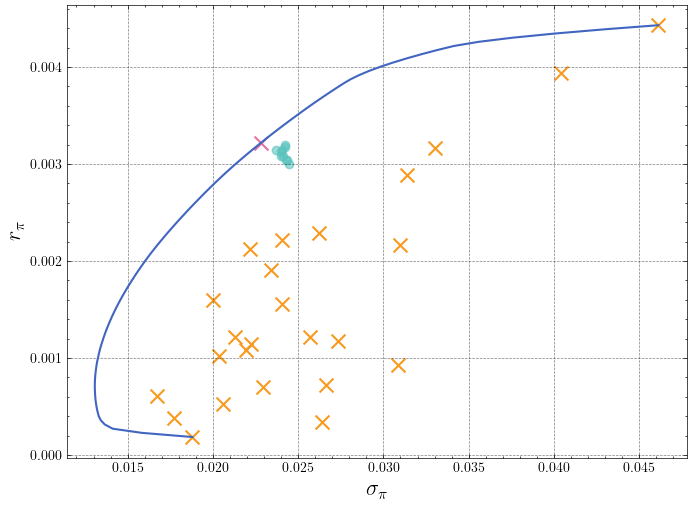

In [151]:
means = []
stds = []
for i in range(len(p_runner.results['0'])):
    means.append(np.mean(p_runner.results['0'][i]))
    stds.append(np.std(p_runner.results['0'][i]))
market.plot_efficient_frontier(stds=stds, returns=means)

### 50 Stocks 

In [143]:
random.shuffle(stocks)
sampled_stocks = stocks[:50]

In [149]:
sampled_stocks

['ADI',
 'MDLZ',
 'CDW',
 'BIIB',
 'IDXX',
 'XEL',
 'PDD',
 'ASML',
 'DOCU',
 'JD',
 'CHTR',
 'SBUX',
 'BKNG',
 'INCY',
 'AAPL',
 'FAST',
 'CSCO',
 'TCOM',
 'MAR',
 'INTC',
 'MTCH',
 'MELI',
 'CDNS',
 'CERN',
 'DXCM',
 'MRVL',
 'CPRT',
 'KDP',
 'CHKP',
 'QCOM',
 'AMZN',
 'XLNX',
 'PTON',
 'ILMN',
 'CMCSA',
 'GOOG',
 'ALXN',
 'MNST',
 'EXC',
 'MSFT',
 'BIDU',
 'FISV',
 'WBA',
 'SPLK',
 'KHC',
 'OKTA',
 'GILD',
 'PEP',
 'MRNA',
 'DLTR']

[*********************100%***********************]  50 of 50 completed


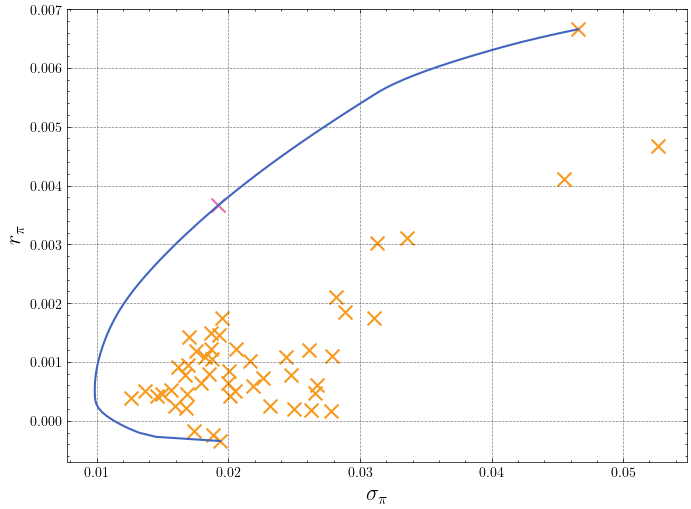

0.1904055077044548

In [144]:
factory = MarketFactory(sampled_stocks, "2015-01-01", "2021-01-01")
market = factory.create_market()
market.plot_efficient_frontier()

In [145]:
params_1 = {
    'n_assets': 50,
    'α': 0.005,
    'α_end': 0.001,
    'start_ep': 9999, 
    'α_decay_steps': 9999,
    'γ': 0.1,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 20000
}



legend_labels = {'0': 'DSR'}

params = [params_1]
p_runner = ParallelRunnerVec(market.μ, market.Σ, 10, params, 100, legend_labels, reward_mode='dsr', η=0.05)
p_runner.run_test()

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 51.91it/s]
1it [1:40:59, 6059.78s/it]


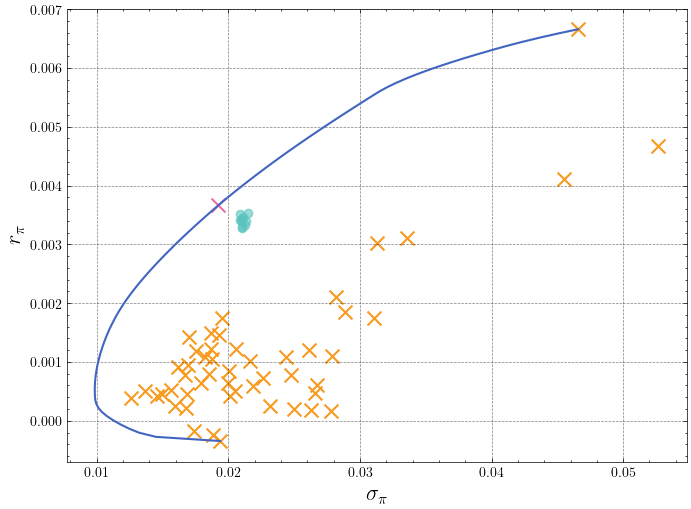

0.1904055077044548

In [148]:
means = []
stds = []
for i in range(len(p_runner.results['0'])):
    means.append(np.mean(p_runner.results['0'][i]))
    stds.append(np.std(p_runner.results['0'][i]))
market.plot_efficient_frontier(stds=stds, returns=means, save_name='./dsr_dir_50')

### 100 Stocks 

In [120]:
random.shuffle(stocks)
sampled_stocks = stocks[:100]

[*********************100%***********************]  100 of 100 completed


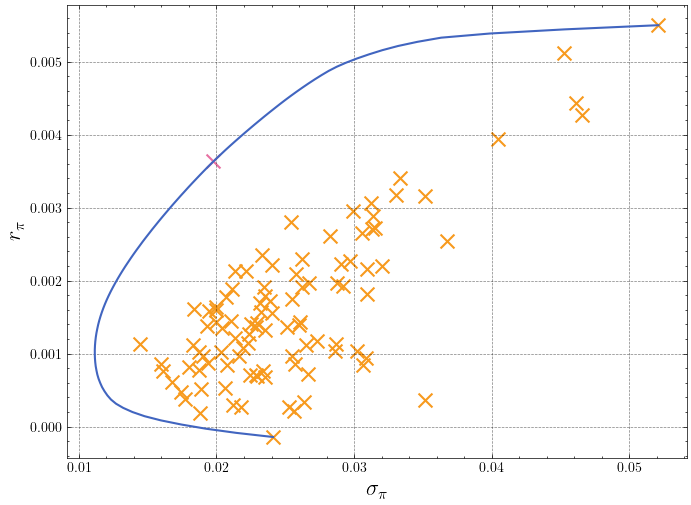

0.18372880956680906

In [130]:
factory = MarketFactory(sampled_stocks, "2019-01-01", "2021-04-30")
market = factory.create_market()
market.plot_efficient_frontier()

In [131]:
params_1 = {
    'n_assets': 100,
    'α': 0.02,
    'α_end': 0.001,
    'start_ep': 6000, 
    'α_decay_steps': 6000,
    'γ': 0.1,
    'grad_adpt_mode': 'natural_gradient',
    'returns_adpt_mode': None,
    'parameterisation': 'softplus',
    'eps': 20000
}



legend_labels = {'0': 'DSR'}

params = [params_1]
p_runner = ParallelRunnerVec(market.μ, market.Σ, 10, params, 100, legend_labels, reward_mode='dsr', η=0.05)
p_runner.run_test()

0it [00:00, ?it/s]
100%|██████████| 10/10 [00:00<00:00, 48.96it/s]
1it [50:12, 3012.96s/it]


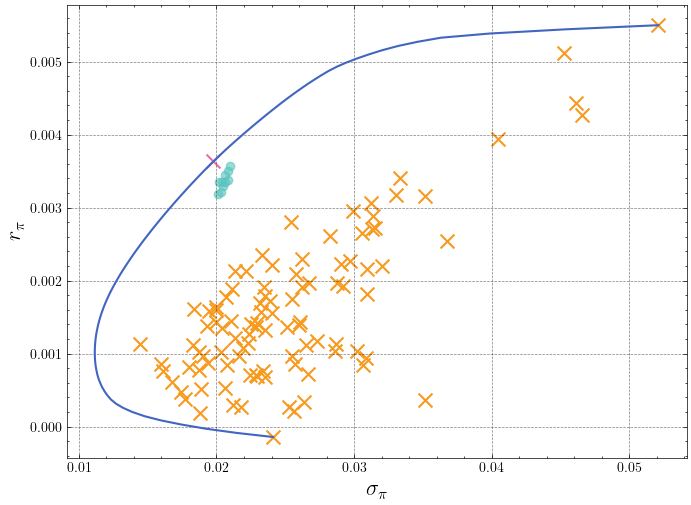

0.18372880956680906

In [133]:
means = []
stds = []
for i in range(len(p_runner.results['0'])):
    means.append(np.mean(p_runner.results['0'][i]))
    stds.append(np.std(p_runner.results['0'][i]))
market.plot_efficient_frontier(stds=stds, returns=means, save_name='dsr_dir_100')

In [165]:
! pip install  numpy_ml

     |████████████████████████████████| 239 kB 3.9 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/opt/python@3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [168]:
import numpy_ml as npml

In [174]:
def d1(x):
    return np.exp(x)/(1 + np.exp(x))

In [175]:
def d2(x):
    return np.exp(x)/((1 + np.exp(x))**2)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])